In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import re
import os
import os.path as osp
import sys
import time
import glob
import cv2
from tqdm import tqdm, tnrange, tqdm_notebook
from collections import OrderedDict


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split, Subset

import torchvision
from torchvision import transforms, datasets, models

from mpl_toolkits.axes_grid1 import ImageGrid

from dataset import CVATDataset, COCODataset
from dataset import variable_shape_collate_fn


from utils import postprocessing, letterbox_label_reverse, bbox_x1y1x2y2_to_xywh, bbox_x1y1x2y2_to_cxcywh, bbox_cxcywh_to_x1y1x2y2, bbox_cxcywh_to_xywh
from draw import show_img, draw_rect, draw_text, \
                 cv2_drawTextWithBkgd, get_color_pallete
from darknet import YoloNet
from train import *

# Paths

In [2]:
weight_path = './yolov3.weights'
backbone_weight_path = './darknet53.conv.74'
classes_path = './x_wing.names'
classes_names = ['x_wing', 'tie']
cvat_img_dir = './custom_data/x_wing'
label_xml_path = './custom_data/7_x_wing.xml'
output_dir = './output'

# Training

## Set up dataloader

In [3]:
def getData(sz, bs, shuffle=True):
    dim = (sz, sz)

    train_ds = CVATDataset(cvat_img_dir, label_xml_path, dim=dim)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=shuffle, num_workers=4)
    
    dataloader = dict()
    dataloader['train'] = train_dl
    dataloader['valid'] = None
    
    return dataloader

## Initial training

In [4]:
lr = 0.01
momentum=0.9
wd=0.0005
sz = 416
bs = 16
lr_scheduler_decay_step = 20
lr_scheduler_decay_gamma = 0.1
darknet53_lr = 0.001
yolo_lr = 0.01

In [7]:
epoch = 100
model_id = 'x_wing_3'
weight_dir_path = './weights'

remove_checkpoints(model_id, weight_dir_path)

net = YoloNet((sz, sz)).cuda()
net.feature.loadWeight(backbone_weight_path)

train(getData(sz, bs), net, epoch,
      lr, darknet53_lr, wd, momentum,
      0, 0, #lr_scheduler_decay_step, lr_scheduler_decay_gamma,
      model_id=model_id, start_epoch=0, weight_dir=weight_dir_path, checkpoint_interval=20,
      resume_checkpoint=None, use_gpu=True)

Epoch     loss_x    loss_y    loss_w    loss_h loss_conf  loss_cls loss_total    recall
    0  0.0029993 0.0030586 0.0045998 0.0043650 0.1095136 0.2108571  0.3353933 0.1562500                                               
    1  0.0027506 0.0028723 0.0031525 0.0028577 0.1036205 0.2080198  0.3232734 0.1614583                                               
    2  0.0021364 0.0022045 0.0014880 0.0014470 0.0937128 0.2039908  0.3049795 0.1927083                                               
    3  0.0028185 0.0028994 0.0015466 0.0022535 0.0830108 0.1986501  0.2911789 0.2213542                                               
    4  0.0028735 0.0029581 0.0009698 0.0011111 0.0721042 0.1917632  0.2717800 0.2135417                                               
    5  0.0020240 0.0020229 0.0008616 0.0010668 0.0619267 0.1841497  0.2520517 0.2161458                                               
    6  0.0025631 0.0025498 0.0013447 0.0012927 0.0542930 0.1729708  0.2350141 0.2083333               

   58  0.0018974 0.0018642 0.0000534 0.0000876 0.0078881 0.0069549  0.0187456 0.6171875                                               
   59  0.0017802 0.0017137 0.0000448 0.0000458 0.0076781 0.0070028  0.0182653 0.6510417                                               
Epoch     loss_x    loss_y    loss_w    loss_h loss_conf  loss_cls loss_total    recall
   60  0.0014686 0.0014319 0.0000345 0.0000466 0.0071026 0.0061172  0.0162014 0.6510417                                               
   61  0.0024559 0.0023474 0.0000822 0.0000744 0.0079505 0.0075465  0.0204569 0.6406250                                               
   62  0.0018456 0.0018322 0.0000445 0.0000560 0.0072017 0.0062870  0.0172669 0.6640625                                               
   63  0.0018154 0.0018416 0.0000531 0.0000600 0.0071463 0.0054496  0.0163659 0.6432292                                               
   64  0.0016277 0.0016352 0.0000327 0.0000457 0.0068008 0.0051529  0.0152950 0.6614583               

## Resume training (make sure 'model_id' matches)

In [5]:
def resume_training(max_epoch, model_id, weight_dir):
    pt_weight_path, latest_epoch = get_latest_checkpoint(model_id, weight_dir)
    if pt_weight_path is not None:
        print('Loading %s' % pt_weight_path)
        
        checkpoint = load_checkpoint(pt_weight_path)
        net = YoloNet((sz, sz)).cuda()
                         
        train(getData(sz, bs), net, max_epoch,
              lr, darknet53_lr,
              wd, momentum,
              0, 0, #lr_scheduler_decay_step, lr_scheduler_decay_gamma,
              model_id=model_id, start_epoch=latest_epoch+1, weight_dir=weight_dir, checkpoint_interval=20,
              resume_checkpoint=checkpoint,
              use_gpu=True)
    else:
        print("No checkpoint for %d found" % model_id)

In [6]:
lr = 0.01
momentum=0.9
wd=0.0005
sz = 416
bs = 16
lr_scheduler_decay_step = 20
lr_scheduler_decay_gamma = 0.1
darknet53_lr = 0.001
yolo_lr = 0.01

In [8]:
#epoch 12 changed loss function
epoch = 320
model_id = 'x_wing_3'
weight_dir = './weights'
resume_training(epoch, model_id, weight_dir)

Loading ./weights/x_wing_3/yolov3_x_wing_3_checkpoint_0299.pth.tar
Epoch     loss_x    loss_y    loss_w    loss_h loss_conf  loss_cls loss_total    recall
  300  0.0005708 0.0005624 0.0000040 0.0000047 0.0001917 0.0000360  0.0013695 0.9556552                                                 
  301  0.0005828 0.0005726 0.0000047 0.0000060 0.0001879 0.0000372  0.0013911 0.9446936                                                 
  302  0.0005679 0.0005668 0.0000041 0.0000042 0.0001836 0.0000348  0.0013615 0.9566517                                                 
  303  0.0005852 0.0005839 0.0000034 0.0000038 0.0001860 0.0000362  0.0013985 0.9566517                                                 
  304  0.0005839 0.0005809 0.0000044 0.0000048 0.0001836 0.0000389  0.0013965 0.9491779                                                 
  305  0.0005721 0.0005665 0.0000037 0.0000046 0.0001830 0.0000387  0.0013686 0.9571500                                                 
  306  0.0005696 0.0005

## Test model on images

In [9]:
def test_model(model_id, classes_names):
    sz = 416
    bs = 16
    dim = (sz, sz)
    weight_dir = './weights'
    output_dir = './output'
       
    dataloader = getData(sz, bs, shuffle=False)['train']
    pt_weight_path, _ = get_latest_checkpoint(model_id, weight_dir)
    print('Loading %s' % pt_weight_path)
    checkpoint = load_checkpoint(pt_weight_path)
    net = YoloNet(dim).cuda().eval()
    net.load_state_dict(checkpoint['net'])
    
    cv2write_detections(net, dataloader, output_dir, classes_names)

def cv2write_detections(net, dataloader, output_dir, classes_names, font_scale=2.0, font=cv2.FONT_HERSHEY_PLAIN, line_width=4):
    bbox_colors = get_color_pallete(20)
    
    with torch.no_grad(): 
        for batch, sample in enumerate(dataloader):
            if batch != 13:
                continue
            
            inp = sample['letterbox_img']
            det1, det2, det3 = net(inp.cuda(), None)
            predictions = postprocessing(torch.cat((det1,det2,det3), 1), 80, obj_conf_thr=0.8, nms_thr=0.4)
            predictions = predictions.cpu()
            
            for i, (img, transform, img_path) in enumerate(zip(sample['org_img'], sample['transform'], sample['img_path'])):
                img = np.ascontiguousarray(img.numpy().transpose(1, 2, 0))
                img_w, img_h = img.shape[1], img.shape[0]
                
                if predictions.shape[0] != 0:
                    img_idx = (predictions[:, 0] == i).nonzero()
                    labels = predictions[img_idx].view(-1, 8).float()

                    for l in labels:
                        box_coord = l[1:5]
                        cls = l[7]

                        cls_text = classes_names[cls.int().item()]
                        cls_color = bbox_colors[cls.int()].numpy().tolist()
                        
                        box_coord[[0,2]] = box_coord[[0,2]] / net.img_dim[1]
                        box_coord[[1,3]] = box_coord[[1,3]] / net.img_dim[0]
                        box_coord = bbox_x1y1x2y2_to_cxcywh(box_coord)
                        box_coord = letterbox_label_reverse(box_coord.double(), transform, net.img_dim)
                        box_coord = bbox_cxcywh_to_x1y1x2y2(box_coord)
                        box_coord[[0,2]] = box_coord[[0,2]] * img_w 
                        box_coord[[1,3]] = box_coord[[1,3]] * img_h 

                        pt1 = tuple(box_coord[0:2].int().numpy().tolist())
                        pt2 = tuple(box_coord[2:4].int().numpy().tolist())

                        img = cv2.rectangle(img, pt1, pt2, cls_color, 4)
                        img = cv2_drawTextWithBkgd(img, cls_text, pt1, cls_color, img_w, img_h, font_scale=font_scale, font=font)
                    
                img = (img * 255).astype(np.int)
                show_img(img, figsize=(16,8))
                #cv2.imwrite(osp.join(output_dir, os.path.basename(img_path)), img)
                #break
                 
            break

Loading ./weights/x_wing_3/yolov3_x_wing_3_checkpoint_0319.pth.tar


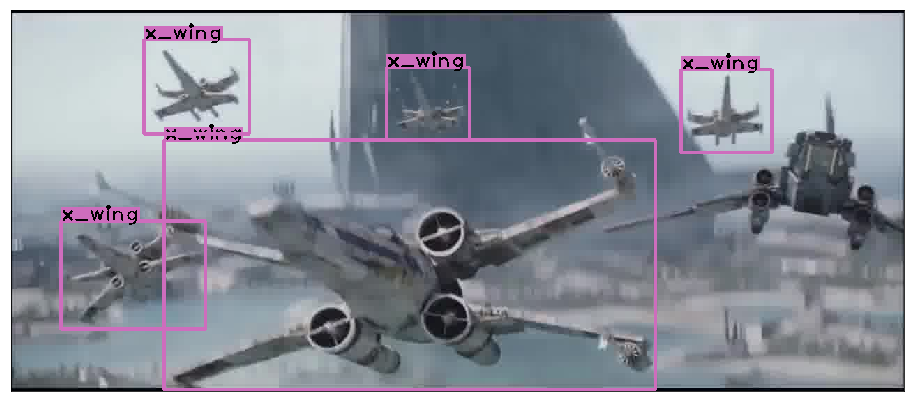

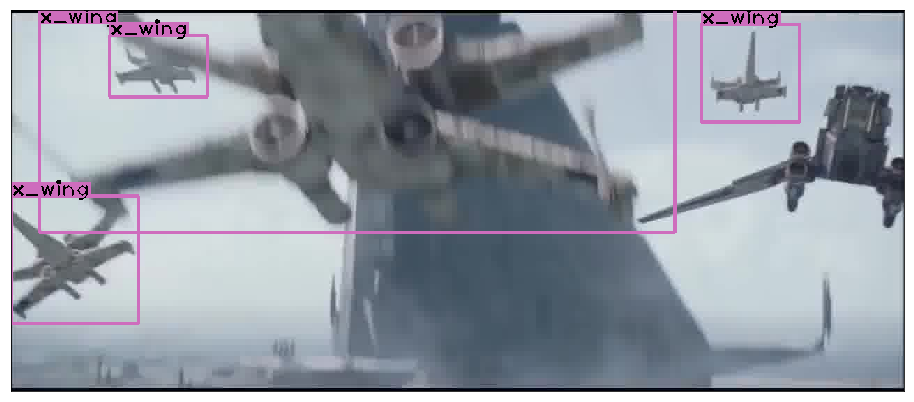

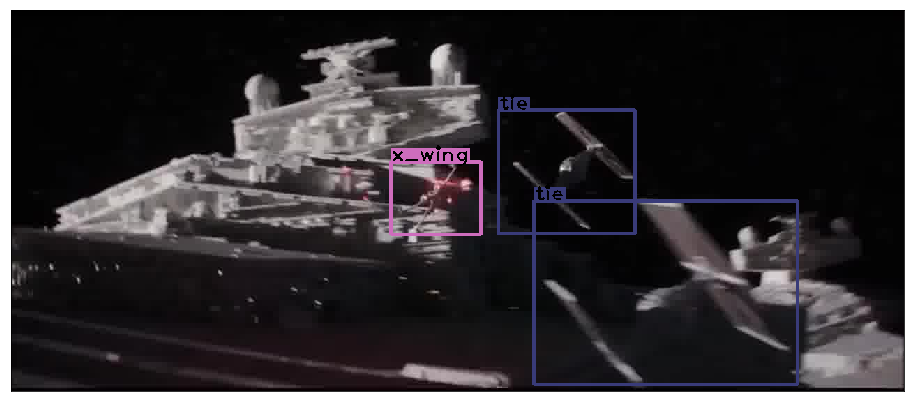

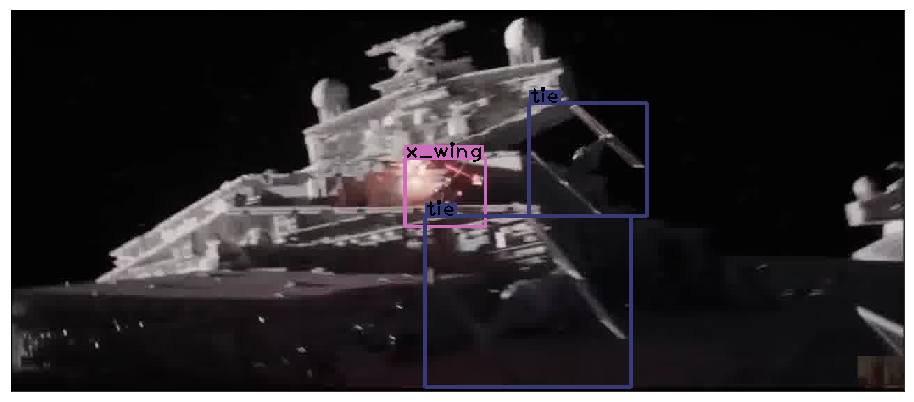

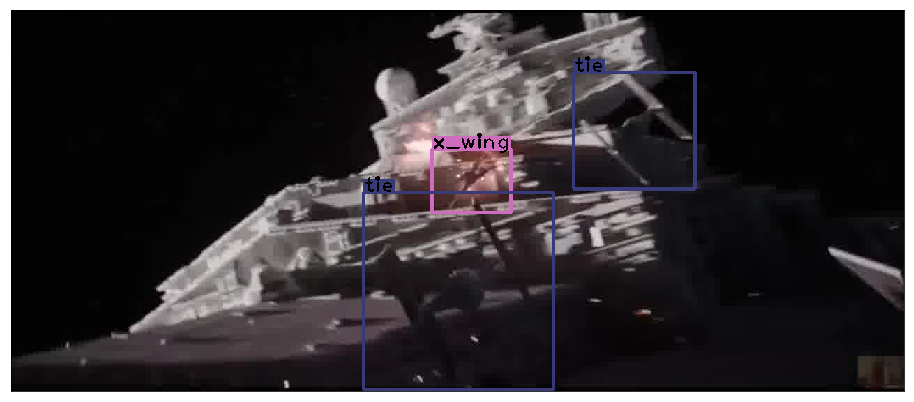

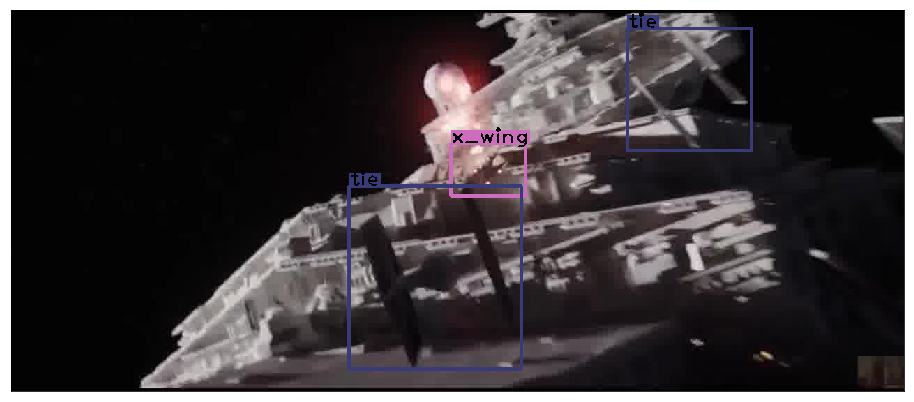

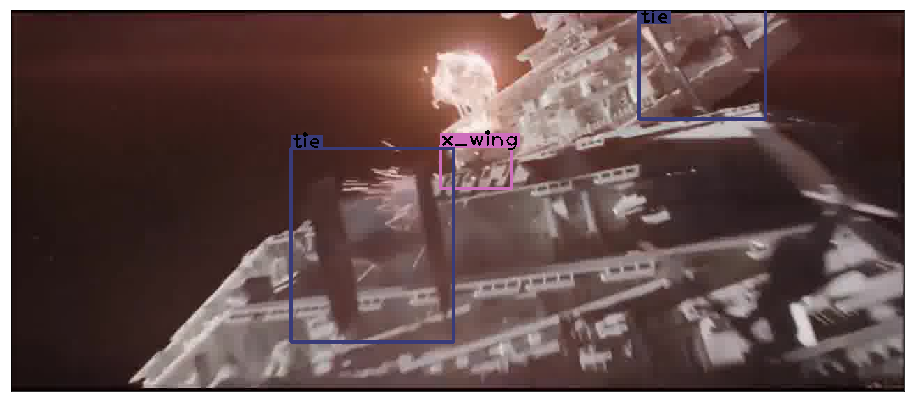

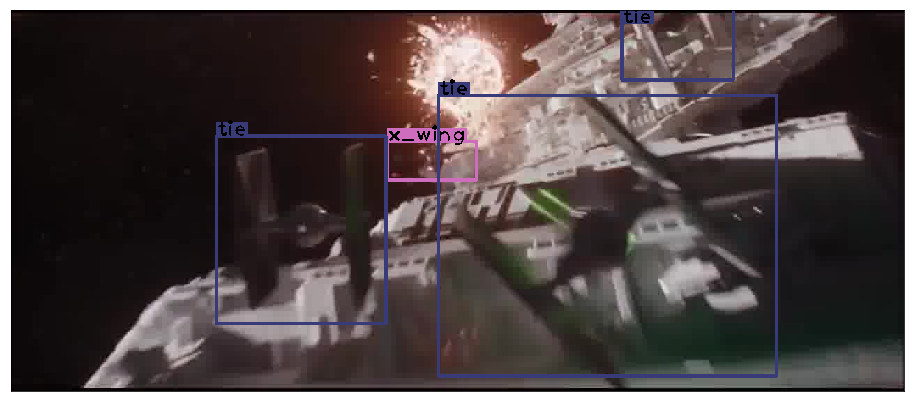

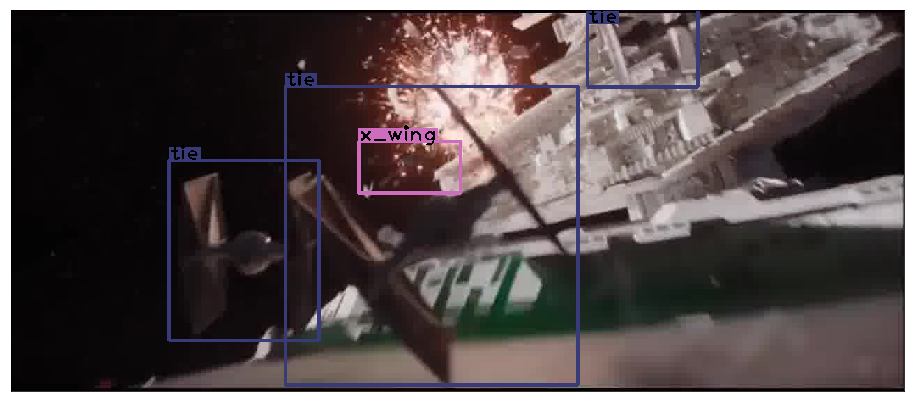

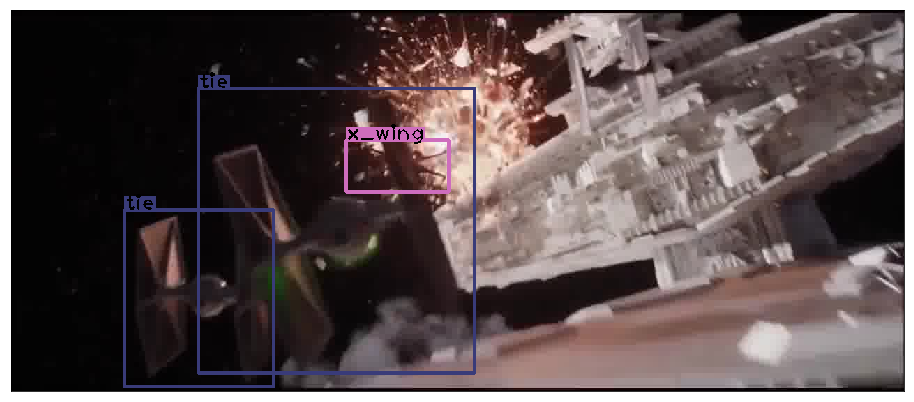

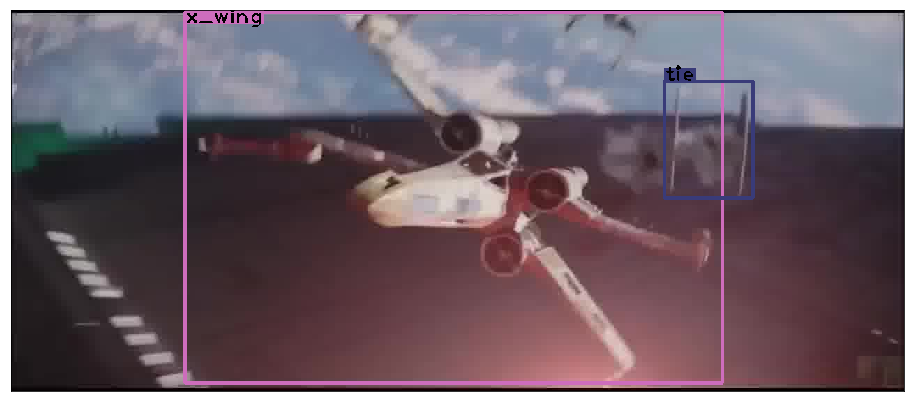

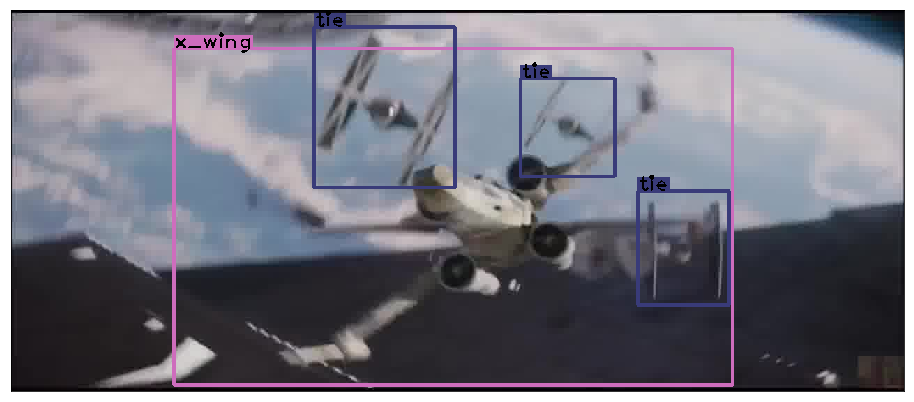

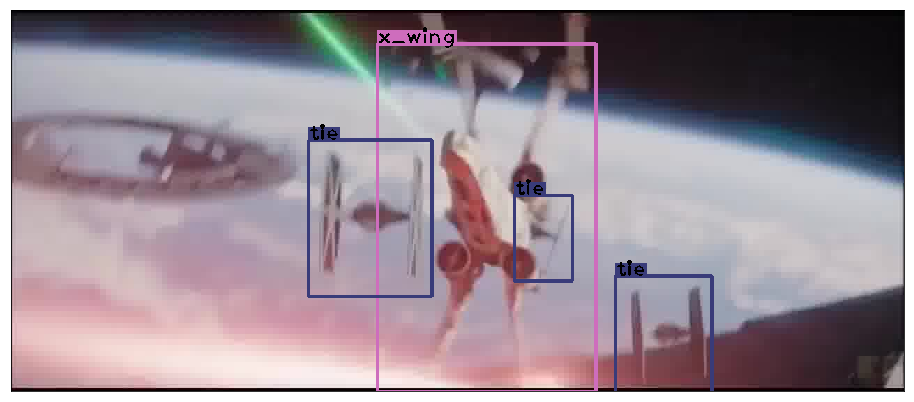

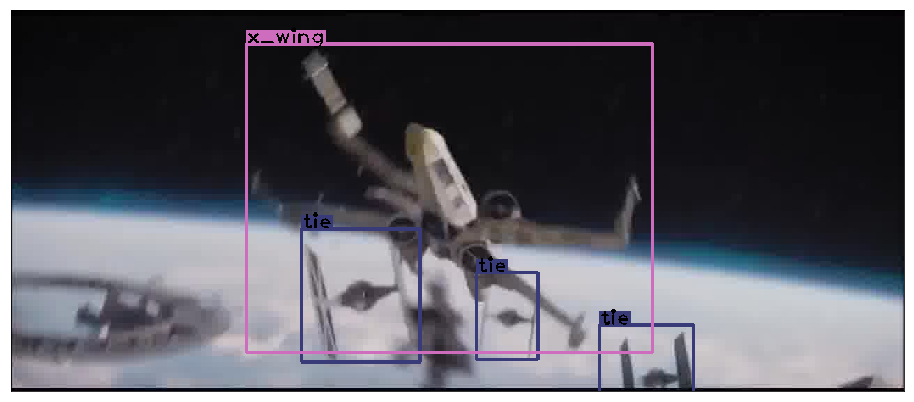

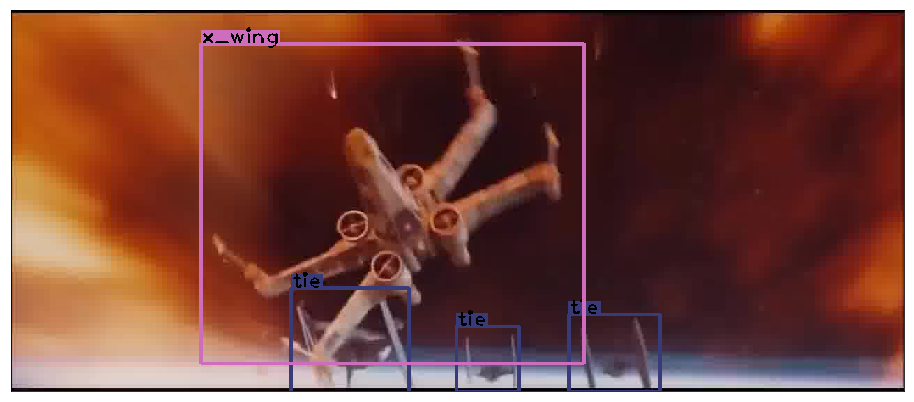

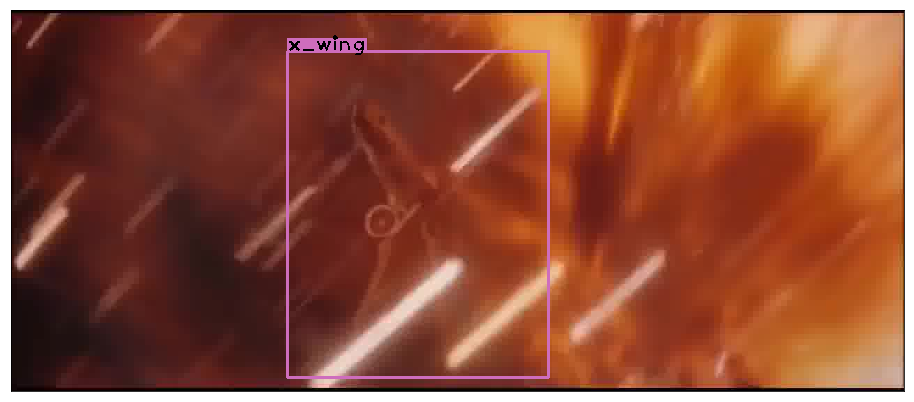

In [10]:
test_model('x_wing_3', classes_names)